# Lab11 - st121413

1. To be done on your own: find another dataset of sentence pairs in a different domain and see if you can preprocess the data and train a chatbot model on it using the same code we developed today. Report your results.

I choosed NLTK.nps_chat as a corpus. Below is how I create my corpus.

The idea is to create bi-gram likes but of each two sentences.

- sent1 sent2
- sent2 sent3
- sent3 sent4
...

In [3]:
import nltk
nltk.download('nps_chat')
from nltk.corpus import nps_chat
nps_chat.fileids()
f = open('nps.txt', 'w')

for id in nps_chat.fileids():
    previous = None
    for words in nps_chat.posts(id):
        sent = ""
        for word in words:
            sent += word + " "
        sent.rstrip(" ")
        if(previous != None):
            toWrite = f"{previous}\t{sent}\n"
            f.write(toWrite)
        previous = sent
f.close()

[nltk_data] Downloading package nps_chat to /root/nltk_data...
[nltk_data]   Package nps_chat is already up-to-date!


## Train result

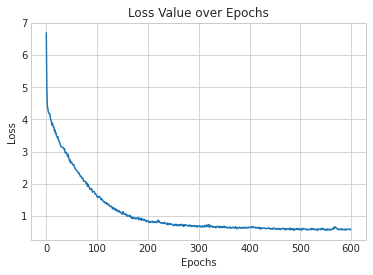

In [1]:
import matplotlib.pyplot as plt
import pickle
plt.style.use('seaborn-whitegrid')

lossvalues = pickle.load(open('loss.pickle','rb'))
plt.plot(lossvalues)
plt.title("Loss Value over Epochs")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [6]:
import torch
from utils import *
from myLSTM import *

checkpoint = torch.load('./content_nps/cb_model/Chat/2-4_512/6000_checkpoint.tar')
print(checkpoint.keys())
model_name = 'cb_model'
attn_model = 'dot'
hidden_size = 512
encoder_n_layers = 2
decoder_n_layers = 4
dropout = 0.5
batch_size = 256 
loadFilename = None

embedding = nn.Embedding(voc.num_words, hidden_size)
embedding.load_state_dict(checkpoint['embedding'])
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, 1391, decoder_n_layers, dropout)
encoder.load_state_dict(checkpoint['en'], strict=False)
decoder.load_state_dict(checkpoint['de'], strict=False)
encoder = encoder.to(device)
decoder = decoder.to(device)


# print(checkpoint.keys())
# torch
# model = TheModelClass(*args, **kwargs)
# optimizer = TheOptimizerClass(*args, **kwargs)


# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

# model.eval()
# # - or -
# model.train()

dict_keys(['iteration', 'en', 'de', 'en_opt', 'de_opt', 'loss', 'voc_dict', 'embedding'])


In [7]:

class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
       
        for _ in range(max_length):
            
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            
            decoder_input = torch.unsqueeze(decoder_input, 0)
        
        return all_tokens, all_scores


In [8]:
datafile = 'nps.txt'
voc, pairs = loadPrepareData(datafile)

# Print some pairs to validate
print("====== Example pairs ======")
for pair in pairs[:10]:
    print(pair)
print("====== ============= ======")


MIN_COUNT = 3    # Minimum word count threshold for trimming
# Trim vocabulary and pairs
pairs = trimRareWords(voc, pairs, MIN_COUNT)
testpairs = pairs[len(pairs)//2:]
pairs  = pairs[:len(pairs)//2]


Start preparing training data ...
Reading lines...
Read 10552 sentence pairs
Trimmed to 8370 sentence pairs
Counting words...
Counted words: 3467
====== Example pairs ======
['now im left with this gay name', 'p']
['p', 'part']
['part', 'hey everyone']
['hey everyone', 'ah well']
['ah well', 'nick u']
['nick u', 'u is a gay name .']
['u is a gay name .', '. action gives u a golf clap .']
['. action gives u a golf clap .', '']
['', 'join']
['join', 'hi u']
====== ============= ======
keep_words 1388 / 3464 = 0.4007
Trimmed from 8370 pairs to 5600, 0.6691 of total


In [18]:
#  Set dropout layers to eval mode
encoder.eval()
decoder.eval()

# Initialize search module
from nltk.translate.bleu_score import sentence_bleu,corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction


searcher = GreedySearchDecoder(encoder, decoder)
gram1_bleu_score = []
gram2_bleu_score = []

# print(testpairs)

for i in range(0,len(testpairs),1):
  input_sentence = testpairs[i][0]
#   print(testpairs[i])
  
  reference = testpairs[i][1:]
  templist = []
  for k in range(len(reference)):
    if(reference[k]!=''):
      temp = reference[k].split(' ')
      templist.append(temp)
  if(templist == []): continue
  
  input_sentence = normalizeString(input_sentence)
  output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
  output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
  chencherry = SmoothingFunction()
#   print(output_words)
#   print(templist)
  score1 = sentence_bleu(templist,output_words,weights=(1, 0, 0, 0) ,smoothing_function=chencherry.method1)
  score2 = sentence_bleu(templist,output_words,weights=(0.5, 0.5, 0, 0),smoothing_function=chencherry.method1) 
#   print(score1)
  gram1_bleu_score.append(score1)
  gram2_bleu_score.append(score2)
  if i%1000 == 0:
    print(i,sum(gram1_bleu_score)/len(gram1_bleu_score),sum(gram2_bleu_score)/len(gram2_bleu_score))
print("Total Bleu Score for 1 grams on testing pairs: ", sum(gram1_bleu_score)/len(gram1_bleu_score) )  
print("Total Bleu Score for 2 grams on testing pairs: ", sum(gram2_bleu_score)/len(gram2_bleu_score) )

0 0.0 0.0
1000 0.10771786340783542 0.046433269691254116
2000 0.0969786912430805 0.04167133791467194
Total Bleu Score for 1 grams on testing pairs:  0.09302291248676885
Total Bleu Score for 2 grams on testing pairs:  0.038758458385426985


In [20]:
# Set dropout layers to eval mode
encoder.eval()
decoder.eval()

# Initialize search module
searcher = GreedySearchDecoder(encoder, decoder)

# Begin chatting (uncomment and run the following line to begin)
evaluateInput(encoder, decoder, searcher, voc)

# Input:
# Me: Hi
# Bot: join u u
# Me: What are you talking about?
# Bot: join u ?
# Me: Good game
# Bot: part . you talking !




Bot: join u u
Bot: join u ?
Error: Encountered unknown word.
Bot: part . you talking !


KeyboardInterrupt: Interrupted by user